In [49]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.fft import fft, ifft, fftfreq
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


### Load and create data for FFT and LDA

In [50]:
# Made some edits!
# Load data
leakage_data = pd.read_csv('../../data/Positive_Meters_Data/Aquatrax_SmallLeak.csv')
nonleakage_data = pd.read_csv('../../data/Negative_Meters_Data/Aquatrax_Nonleakage_Data_20accounts.csv')

# Cleaning datasets
nonleakage_data = nonleakage_data.rename({'Usagedate': 'UsageDate', 'Meternumber': 'MeterNumber'}, axis='columns') #rename columns
leakage_data = leakage_data.rename({'Usagedate': 'UsageDate', 'Meternumber': 'MeterNumber'}, axis='columns') #rename columns
leakage_data = leakage_data.iloc[:,:4]

# Combine the datasets
leakage_data['Class'] = 1  # Indicate leakage
nonleakage_data['Class'] = 0  # Indicate non-leakage



combined_data = pd.concat([leakage_data, nonleakage_data])

# Sort by MeterNumber and UsageDate
combined_data.sort_values(by=['MeterNumber', 'UsageDate'], inplace=True)

# Reset index after sorting
combined_data.reset_index(drop=True, inplace=True)

# Create UsageRatio col
combined_data['UsageRatio'] = pd.NA

# Iterate over account numbers
for num in combined_data['AccountNumber'].unique():
    # Pull data for each account number
    subset = combined_data[combined_data['AccountNumber'] == num]
    
    # Count values for each condition
    non_zero_count = (subset['Value'] > 0).sum()
    zero_count = (subset['Value'] == 0).sum()
    
    # Calculate usage ratio (nonzero-to-zero)
    usage_ratio = non_zero_count / zero_count if zero_count != 0 else pd.NA
    combined_data.loc[combined_data['AccountNumber'] == num, 'UsageRatio'] = usage_ratio

# Store usage ratios as df for later
unique_account_numbers = combined_data['AccountNumber'].unique()
usage_ratios = combined_data.groupby('AccountNumber')['UsageRatio'].first().values

# Create a new dataframe usage_ratio_vals
usage_ratio_vals = pd.DataFrame({'AccountNumber': unique_account_numbers, 'UsageRatio': usage_ratios})

combined_data


,AccountNumber,UsageDate,Value,MeterNumber,Class,UsageRatio
0,0050005-28920,01-01-2023 00:00,2,0050005-10450-1,0,0.101412
1,0050005-28920,01-01-2023 01:00,0,0050005-10450-1,0,0.101412
2,0050005-28920,01-01-2023 02:00,0,0050005-10450-1,0,0.101412
3,0050005-28920,01-01-2023 03:00,0,0050005-10450-1,0,0.101412
4,0050005-28920,01-01-2023 04:00,0,0050005-10450-1,0,0.101412
...,...,...,...,...,...,...
299163,5751740-68085,12-31-2022 19:00,1,5751740-10450-1,1,9.37798
299164,5751740-68085,12-31-2022 20:00,0,5751740-10450-1,1,9.37798
299165,5751740-68085,12-31-2022 21:00,1,5751740-10450-1,1,9.37798
299166,5751740-68085,12-31-2022 22:00,2,5751740-10450-1,1,9.37798


In [51]:
#truncate each account number to have same length = threshold
LEN_THRES = 7500
df_account_list = [combined_data[combined_data['AccountNumber'] == number].tail(LEN_THRES) for number in combined_data['AccountNumber'].unique()]
for (idx, df_account) in enumerate(df_account_list):
    if (len(df_account) < LEN_THRES):  #remove account if total number of datapoints below threshold
        dropping_meter_number = df_account.loc[:].reset_index()['MeterNumber'][0]
        combined_data = combined_data.drop(combined_data[combined_data['MeterNumber']==dropping_meter_number].index)
        del df_account_list[idx]
[len(e) for e in df_account_list]  #display number of data points for each account

[7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500]

In [52]:
print(len(df_account_list[0]))

7500


In [53]:
#need to run the above block before running this one!!

#list to store pivoted account dataframes
df_account_pivoted_list = []

#conduct fourier transfor on each account
for (idx, df_account) in enumerate(df_account_list):
    df_account['FFT_F'] = fftfreq(len(df_account), 1)
    df_account['FFT_Period'] = 1/df_account['FFT_F']
    df_account['FFT'] = fft(df_account['Value'])
    df_account['FFTA'] = np.abs(df_account['FFT'])

    #only keep periods from 0 to 30
    df_account = df_account.where(df_account['FFT_Period'] <= 30)
    df_account = df_account.where(df_account['FFT_Period'] >= 0)
    df_account = df_account.dropna()
    df_account_list[idx] = df_account

    #pivot each account dataframe
    df_account_pivoted = df_account.pivot(index="AccountNumber", columns='FFT_Period', values='FFTA')
    df_account_pivoted_list.append(df_account_pivoted)

df_account_pivoted_list[0]  #this shows 0 na's in dataframe


FFT_Period,2.000533,2.001067,2.001601,2.002136,2.002670,2.003205,2.003740,2.004276,2.004812,2.005348,...,28.957529,29.069767,29.182879,29.296875,29.411765,29.527559,29.644269,29.761905,29.880478,30.000000
AccountNumber,,,,,,,,,,,,,,,,,,,,,
0050005-28920,124.149343,158.141899,64.938147,77.6017,42.662195,32.74185,56.084477,78.939669,116.762542,58.775317,...,238.048828,76.731557,129.04646,135.396546,23.000038,144.750595,114.800729,188.035079,99.025246,54.685236


In [70]:
# combine all pivoted account dataframes
df_accounts_pivoted = pd.concat(df_account_pivoted_list)

# merge with stored usage ratios
#df_accounts_pivoted = pd.merge(df_accounts_pivoted, usage_ratio_vals, on='AccountNumber', how='left')
df_account_pivoted = pd.concat()

df_accounts_pivoted

FFT_Period,2.000533,2.001067,2.001601,2.002136,2.002670,2.003205,2.003740,2.004276,2.004812,2.005348,...,28.957529,29.069767,29.182879,29.296875,29.411765,29.527559,29.644269,29.761905,29.880478,30.000000
AccountNumber,,,,,,,,,,,,,,,,,,,,,
0050005-28920,124.149343,158.141899,64.938147,77.601700,42.662195,32.741850,56.084477,78.939669,116.762542,58.775317,...,238.048828,76.731557,129.046460,135.396546,23.000038,144.750595,114.800729,188.035079,99.025246,54.685236
0050015-328466,93.004434,141.689065,73.804858,223.741081,35.797403,180.564034,243.925734,180.280827,67.842767,119.784359,...,155.332205,117.969219,195.837020,206.763755,142.203437,178.467594,181.858867,239.481152,138.442607,90.814993
0050017-668118,120.551459,67.625835,167.578027,64.648633,132.422852,92.543808,146.455887,29.508063,119.969151,105.468388,...,264.435066,57.583345,168.380393,44.993817,40.738750,82.817134,71.018653,111.557355,42.628413,69.589964
0050020-660260,385.779023,315.186462,171.289129,66.388887,133.261003,91.737888,18.871754,71.030641,116.514351,16.324206,...,57.550918,87.091262,172.284751,52.302249,148.980265,68.286694,147.942500,93.928796,66.252341,70.888698
0050100-50430,95.891447,48.473892,61.564863,107.176587,42.742959,142.269649,118.328452,206.675077,35.331375,35.663511,...,134.429189,233.952047,214.846123,45.115045,244.506983,187.838806,344.418958,144.246943,342.090265,162.693075
0050110-26,1523.172081,283.062982,419.868545,375.451790,1019.443900,252.327860,295.287807,252.288357,289.774121,30.954790,...,58.831910,106.586450,136.837330,26.424128,42.683590,32.879654,148.685412,93.774045,74.651877,26.262934
0050180-66814,108.052711,76.353429,71.778807,30.874499,34.146556,64.364508,97.605455,79.815960,69.003109,33.216697,...,53.481037,13.975070,26.464456,25.867598,78.002774,65.517646,12.793066,62.846760,142.358608,37.606374
0050200-530518,149.218293,73.624128,107.684366,141.472854,146.548201,135.756501,94.369048,86.328719,83.233575,149.702229,...,235.832302,70.663081,306.032763,77.786461,117.817455,146.598468,122.379976,132.291912,96.846777,86.389453
0050240-149921,651.176825,132.546341,246.136602,138.109439,208.087396,190.033506,179.145157,200.073390,184.662005,226.743421,...,397.397238,408.541545,746.565831,242.616275,165.630675,524.663173,340.697592,277.190162,60.483246,332.748656


In [55]:
print(len(df_account_pivoted_list))

33


### Perform FFT

In [56]:
# fft_features = []

# for meter_number in combined_data['MeterNumber'].unique():
#     meter_data = combined_data[combined_data['MeterNumber'] == meter_number]
#     fft_result = np.abs(fft(meter_data['Value']))
#     fft_features.append(fft_result)

# # Create a new DataFrame with FFT features
# fft_df = pd.DataFrame(fft_features)

# fft_df.head()


In [57]:
#testing data formats
# np.array(df_accounts_pivoted) #m meter accounts, n fft features, m x n matrix
# combined_data.loc[combined_data['MeterNumber'] == '0050005-10450-1']['Class'][0]
# meter_number = '0050005-10450-1'
# combined_data.loc[combined_data['MeterNumber'] == meter_number]['Class'][0]

# [combined_data.loc[combined_data['MeterNumber'] == meter_number]['Class'][0] for meter_number in combined_data['MeterNumber'].unique()]

### Perform and evaluate LDA

In [58]:
# Perform LDA
X = np.array(df_accounts_pivoted)
y = np.array([combined_data.loc[combined_data['MeterNumber'] == meter_number].reset_index()['Class'][0] for meter_number in combined_data['MeterNumber'].unique()])
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
lda.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [59]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.7857142857142857
Confusion Matrix:
[[10  0]
 [ 3  1]]


In [60]:
np.sort(np.abs(lda.coef_))

array([[1.11051488e-09, 7.26818045e-09, 7.96265597e-09, ...,
        4.49275001e-04, 6.19452124e-04, 7.29623113e-04]])

In [61]:
lda_coefficients = lda.coef_

for i in range(33):
    print(lda_coefficients[0][i])

7.3378192981854805e-06
3.2146620987077132e-06
1.9433190899909638e-05
-2.57205616998261e-05
1.3952780695930206e-05
7.268180450364962e-09
3.9379113798925026e-05
-9.189291191236369e-06
2.9460210150824466e-05
-3.2961168914152004e-06
3.137397441738982e-05
6.788960032558826e-06
-1.4074874450090768e-06
-1.4090534038842616e-06
-8.872862042240664e-06
-9.44699233754033e-05
-0.00011875966584301971
4.1107539656670125e-05
0.00013788125387437944
3.082249243036033e-05
-3.7250825880614586e-05
0.00021719368423185137
-1.5914210378349687e-05
-3.958792334942123e-05
-0.00011060689151676974
-4.27139436593525e-05
-5.66803288532675e-05
2.029613542040204e-05
2.5487111152570582e-05
0.00012306322578710353
-7.82700414076641e-05
8.016317929097371e-05
-0.00017845668022620817


In [62]:
lda_scalings = lda.scalings_

for i in range(33):
    print(lda_scalings[i])

[2.55547663e-06]
[1.11954159e-06]
[6.76782341e-06]
[-8.95746975e-06]
[4.85921002e-06]
[2.53122414e-09]
[1.37142114e-05]
[-3.20027217e-06]
[1.02598436e-05]
[-1.14790912e-06]
[1.09263332e-05]
[2.36433033e-06]
[-4.90173052e-07]
[-4.90718414e-07]
[-3.09007223e-06]
[-3.29001945e-05]
[-4.13593656e-05]
[1.43161548e-05]
[4.80186699e-05]
[1.07342735e-05]
[-1.29730116e-05]
[7.56400999e-05]
[-5.54229957e-06]
[-1.37869316e-05]
[-3.85200719e-05]
[-1.48756028e-05]
[-1.97395507e-05]
[7.06835338e-06]
[8.87616802e-06]
[4.28581279e-05]
[-2.72584066e-05]
[2.79177128e-05]
[-6.21495103e-05]


In [63]:
lda_scalings

array([[2.55547663e-06],
       [1.11954159e-06],
       [6.76782341e-06],
       ...,
       [2.56150716e-05],
       [3.51480975e-05],
       [2.36425283e-05]])

In [64]:
sorted_coef = np.sort(np.abs(lda.coef_)[0])[::-1]
sorted_coef = -1*sorted_coef
sorted_coef

array([-7.29623113e-04, -6.19452124e-04, -4.49275001e-04, ...,
       -7.96265597e-09, -7.26818045e-09, -1.11051488e-09])

In [65]:
ranked_indices_desc = np.argsort(lda.coef_[0])[::-1]
ranked_indices_desc

array([1185,   35,  262, ..., 3356,  273,  246])

In [66]:
df_account_pivoted.keys()

Index([2.0005334755934916, 2.0010672358591246,   2.00160128102482,
         2.00213561131874, 2.0026702269692924,  2.003205128205128,
        2.003740315255143, 2.0042757883484765, 2.0048115477145148,
       2.0053475935828877,
       ...
       28.957528957528957, 29.069767441860463, 29.182879377431906,
                29.296875,  29.41176470588235, 29.527559055118108,
       29.644268774703555,  29.76190476190476, 29.880478087649404,
                     30.0],
      dtype='float64', name='FFT_Period', length=3500)

In [67]:
lda.decision_function(X=X)

array([-3.27560376, -4.66338773, -2.51314659, -3.61952876, -2.84723267,
       -1.15221572, -0.53974211, -4.59731793, -0.91951882, -2.95007011,
       -5.14304189, -5.14720333, -2.25282257, -3.11057744, -4.92007067,
       -2.01978937, -3.29578087, -1.04928699, -5.01077676, -1.88328477,
       -5.91286739, -1.53835561,  3.89049663,  5.55798018,  5.7839894 ,
        5.8421526 ,  4.16102407,  5.71228895,  3.79400556,  5.44881115,
        6.24881057, -2.11536118,  5.91289353])

In [68]:
lda.transform(X=X)

array([[-1.25302156],
       [-1.73633266],
       [-0.98748743],
       [-1.37279724],
       [-1.1038366 ],
       [-0.51352822],
       [-0.30022752],
       [-1.71332312],
       [-0.43248895],
       [-1.13965087],
       [-1.90337752],
       [-1.90482679],
       [-0.89682671],
       [-1.19554932],
       [-1.82572533],
       [-0.81567033],
       [-1.26004846],
       [-0.47768215],
       [-1.85731473],
       [-0.76813109],
       [-2.17147775],
       [-0.6480057 ],
       [ 1.24265206],
       [ 1.82337163],
       [ 1.90208184],
       [ 1.92233782],
       [ 1.33686624],
       [ 1.87711137],
       [ 1.20904798],
       [ 1.78535231],
       [ 2.06396095],
       [-0.84895427],
       [ 1.94697413]])

In [69]:
lda.n_components_

AttributeError: 'LinearDiscriminantAnalysis' object has no attribute 'n_components_'

In [ ]:
#Top five periods/features for linear discriminant
df_accounts_pivoted.keys()[ranked_indices_desc[0:5]]

Float64Index([2.9251170046801866, 2.0193861066235863,  2.150845999426441,
               2.903600464576074,  2.261079288513717],
             dtype='float64', name='FFT_Period')

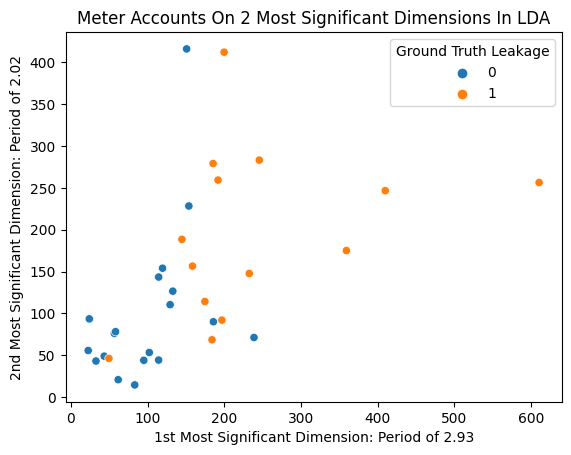

In [ ]:
#Plot LDA with Scatter Plot of Meters
#Define the 2 dimensions
(key1, key2) = df_accounts_pivoted.keys()[ranked_indices_desc[0:2]]

#Create line boundary from LDA
# linemesh = np.meshgrid(np.linspace(0, 500, 500), np.linspace(0,700, 700))
# linemesh = np.swapaxes(linemesh, 0, 2)
# linemesh = np.swapaxes(linemesh, 0, 1)
# linemesh = linemesh.reshape(-1,2)
# line = lda.decision_function(linemesh)

sns.scatterplot(x=df_accounts_pivoted[key1],y=df_accounts_pivoted[key2], hue=y)  #color: y
plt.xlabel(f'1st Most Significant Dimension: Period of {key1:.2f}')
plt.ylabel(f'2nd Most Significant Dimension: Period of {key2:.2f}')
plt.title('Meter Accounts On 2 Most Significant Dimensions In LDA')
plt.legend(title='Ground Truth Leakage', loc='upper right')


## Create per-account ratio of nonzero to zero usage hour count 

In [ ]:
# # Create UsageRatio col
# combined_data['UsageRatio'] = pd.NA

# # Iterate over account numbers
# for num in combined_data['AccountNumber'].unique():
#     # Pull data for each account number
#     subset = combined_data[combined_data['AccountNumber'] == num]
    
#     # Count values for each condition
#     non_zero_count = (subset['Value'] > 0).sum()
#     zero_count = (subset['Value'] == 0).sum()
    
#     # Calculate usage ratio (nonzero-to-zero)
#     usage_ratio = non_zero_count / zero_count if zero_count != 0 else pd.NA
#     combined_data.loc[combined_data['AccountNumber'] == num, 'UsageRatio'] = usage_ratio

# combined_data

,AccountNumber,UsageDate,Value,MeterNumber,Class,UsageRatio
0,0050005-28920,01-01-2023 00:00,2,0050005-10450-1,0,0.101412
1,0050005-28920,01-01-2023 01:00,0,0050005-10450-1,0,0.101412
2,0050005-28920,01-01-2023 02:00,0,0050005-10450-1,0,0.101412
3,0050005-28920,01-01-2023 03:00,0,0050005-10450-1,0,0.101412
4,0050005-28920,01-01-2023 04:00,0,0050005-10450-1,0,0.101412
...,...,...,...,...,...,...
299163,5751740-68085,12-31-2022 19:00,1,5751740-10450-1,1,9.37798
299164,5751740-68085,12-31-2022 20:00,0,5751740-10450-1,1,9.37798
299165,5751740-68085,12-31-2022 21:00,1,5751740-10450-1,1,9.37798
299166,5751740-68085,12-31-2022 22:00,2,5751740-10450-1,1,9.37798
